# All Weather Strategy v1.1 - US Markets

Pure risk parity implementation for US ETFs using yfinance data.

**ETF Universe (8 ETFs)**:
- **Stocks**: SPY (S&P 500), QQQ (Nasdaq), IWM (Russell 2000)
- **Bonds**: TLT (20+ yr Treasury), IEF (7-10 yr Treasury), TIP (TIPS)
- **Commodities**: GLD (Gold), DBC (Broad commodities)

**Strategy**: Pure risk parity, weekly rebalancing, 252-day lookback

## 1. Setup & Imports

In [ ]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader_us import (
    download_us_etfs,
    get_all_weather_us_etfs,
    check_us_data_quality,
    save_us_data
)
from src.strategy_us import AllWeatherUS
from src.optimizer import optimize_weights, risk_contribution, check_risk_parity
from src.metrics import calculate_all_metrics

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

pd.options.display.float_format = '{:.4f}'.format

print("✓ Imports successful")

✓ Imports successful


## 2. Download US ETF Data

Download historical data from yfinance for our All Weather ETF universe.

In [ ]:
# Get ETF universe
etf_info = get_all_weather_us_etfs()

print("All Weather US ETF Universe:")
print("="*80)
for ticker, info in etf_info.items():
    print(f"{ticker:6} | {info['asset_class']:12} | {info['name']}")
    print(f"       | {' '*12} | {info['description']}")
    print()

# Download data
tickers = list(etf_info.keys())
prices = download_us_etfs(
    tickers=tickers,
    start_date='2015-01-01',
    progress=True
)

All Weather US ETF Universe:
SPY    | Stocks       | SPDR S&P 500 ETF
       |              | US large-cap stocks (S&P 500)

QQQ    | Stocks       | Invesco QQQ Trust
       |              | US tech stocks (Nasdaq-100)

IWM    | Stocks       | iShares Russell 2000 ETF
       |              | US small-cap stocks

TLT    | Bonds        | iShares 20+ Year Treasury Bond ETF
       |              | Long-term US Treasury bonds

IEF    | Bonds        | iShares 7-10 Year Treasury Bond ETF
       |              | Intermediate-term US Treasury bonds

TIP    | Bonds        | iShares TIPS Bond ETF
       |              | Inflation-protected Treasury bonds

GLD    | Commodities  | SPDR Gold Shares
       |              | Physical gold

DBC    | Commodities  | Invesco DB Commodity Index Tracking Fund
       |              | Broad commodity index

Period: 2015-01-01 to 2026-01-29
Tickers: SPY, QQQ, IWM, TLT, IEF, TIP, GLD, DBC


[*********************100%***********************]  8 of 8 completed


✓ Downloaded 2784 days of data
  Date range: 2015-01-02 to 2026-01-28


## 3. Data Quality Check

In [ ]:
# Check data quality
quality_df = check_us_data_quality(prices, verbose=True)

# Display summary
print("\n" + "="*80)
print("Data ready for backtesting!")
print(f"Period: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"ETFs: {len(prices.columns)}")
print(f"Days: {len(prices)}")


US ETF DATA QUALITY REPORT

DBC:
  Period: 2015-01-02 to 2026-01-28
  Days: 2784
  Missing: 0.00%
  Zero returns: 2.12%
  Mean daily return: 0.0002
  Daily volatility: 0.0111
  Price range: $9.14 - $26.57
  Latest price: $24.94

GLD:
  Period: 2015-01-02 to 2026-01-28
  Days: 2784
  Missing: 0.00%
  Zero returns: 0.29%
  Mean daily return: 0.0006
  Daily volatility: 0.0094
  Price range: $100.50 - $494.56
  Latest price: $494.56

IEF:
  Period: 2015-01-02 to 2026-01-28
  Days: 2784
  Missing: 0.00%
  Zero returns: 0.68%
  Mean daily return: 0.0001
  Daily volatility: 0.0042
  Price range: $81.97 - $107.75
  Latest price: $95.90

IWM:
  Period: 2015-01-02 to 2026-01-28
  Days: 2784
  Missing: 0.00%
  Zero returns: 0.22%
  Mean daily return: 0.0004
  Daily volatility: 0.0142
  Price range: $83.27 - $269.79
  Latest price: $263.30

QQQ:
  Period: 2015-01-02 to 2026-01-28
  Days: 2784
  Missing: 0.00%
  Zero returns: 0.14%
  Mean daily return: 0.0008
  Daily volatility: 0.0138
  Price ran

## 4. Calculate Current Risk Parity Weights

In [ ]:
# Calculate weights using latest 252 days
recent_returns = prices.tail(252).pct_change().dropna()
weights = optimize_weights(recent_returns)

# Check risk parity
cov_matrix = recent_returns.cov()
is_rp, std_rc = check_risk_parity(weights, cov_matrix)
print(f"Risk parity achieved: {is_rp} (std={std_rc:.6f})")

# Display allocation
allocation = pd.DataFrame({
    'Ticker': prices.columns,
    'Asset Class': [etf_info[t]['asset_class'] for t in prices.columns],
    'Weight': weights,
    'Allocation %': weights * 100
}).sort_values('Weight', ascending=False)

print("\nCurrent Risk Parity Allocation:")
print(allocation.to_string(index=False))

# Group by asset class
by_class = allocation.groupby('Asset Class')['Allocation %'].sum().sort_values(ascending=False)
print("\nBy Asset Class:")
for asset_class, pct in by_class.items():
    print(f"  {asset_class:12}: {pct:.1f}%")

Risk parity achieved: True (std=0.000000)

Current Risk Parity Allocation:
Ticker Asset Class  Weight  Allocation %
   IEF       Bonds  0.2813       28.1324
   TIP       Bonds  0.2669       26.6873
   TLT       Bonds  0.1054       10.5433
   DBC Commodities  0.1017       10.1718
   GLD Commodities  0.0823        8.2315
   SPY      Stocks  0.0586        5.8581
   QQQ      Stocks  0.0524        5.2425
   IWM      Stocks  0.0513        5.1332

By Asset Class:
  Bonds       : 65.4%
  Commodities : 18.4%
  Stocks      : 16.2%


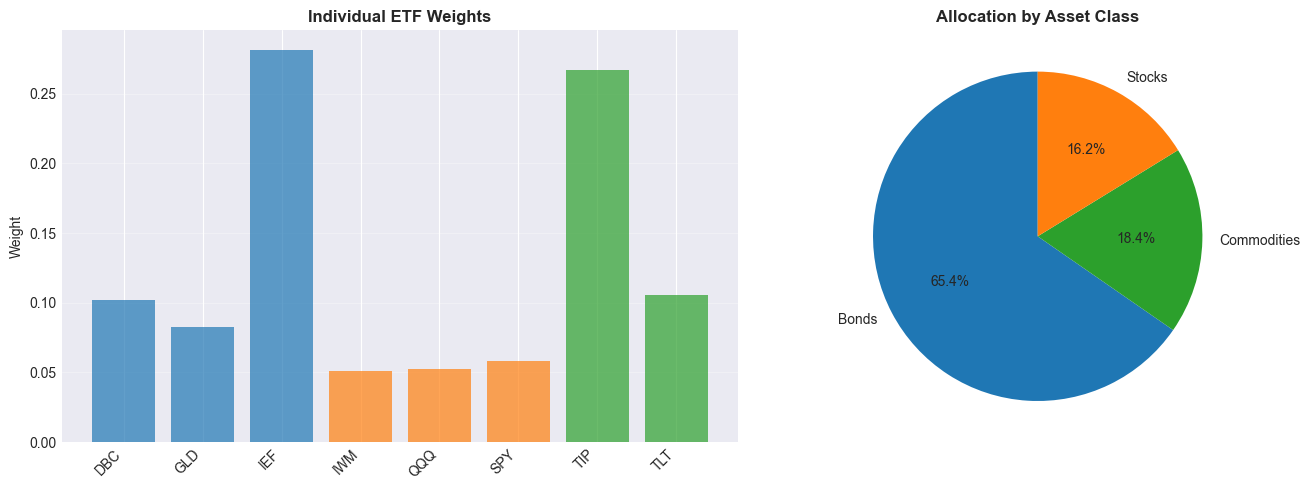

In [ ]:
# Visualize allocation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Individual weights
colors = ['#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#ff7f0e', '#2ca02c', '#2ca02c']
ax1.bar(range(len(weights)), weights, color=colors, alpha=0.7)
ax1.set_xticks(range(len(weights)))
ax1.set_xticklabels(prices.columns, rotation=45, ha='right')
ax1.set_title('Individual ETF Weights', fontsize=12, fontweight='bold')
ax1.set_ylabel('Weight')
ax1.grid(True, alpha=0.3, axis='y')

# By asset class
ax2.pie(by_class.values, labels=by_class.index, autopct='%1.1f%%',
        colors=['#1f77b4', '#2ca02c', '#ff7f0e'], startangle=90)
ax2.set_title('Allocation by Asset Class', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Run Backtest

In [ ]:
# Initialize strategy
strategy = AllWeatherUS(
    prices=prices,
    initial_capital=100_000,  # $100,000
    rebalance_freq='W-MON',    # Weekly Monday
    lookback=252,              # 1 year
    commission_rate=0.001      # 0.1% (typical for US stocks)
)

# Run backtest from 2018
print("Running backtest from 2018-01-01...\n")
results = strategy.run_backtest(start_date='2018-01-01')

print("\n" + "="*60)
print("Backtest Complete!")
print("="*60)
print(f"Final Value: ${results['final_value']:,.0f}")
print(f"Total Return: {results['total_return']:.2%}")
print(f"Rebalances: {results['rebalance_count']}")
print(f"Trades: {results['trade_count']}")
print(f"Total Commissions: ${results['total_commissions']:,.0f}")
print(f"Turnover: {results['turnover']:.2f}x")

Running backtest from 2018-01-01...

Backtest: 2018-01-01 to 2026-01-28
Rebalances: 422

Backtest Complete!
Final Value: $128,682
Total Return: 28.68%
Rebalances: 380
Trades: 99
Total Commissions: $707
Turnover: 7.07x


## 6. Plot Performance

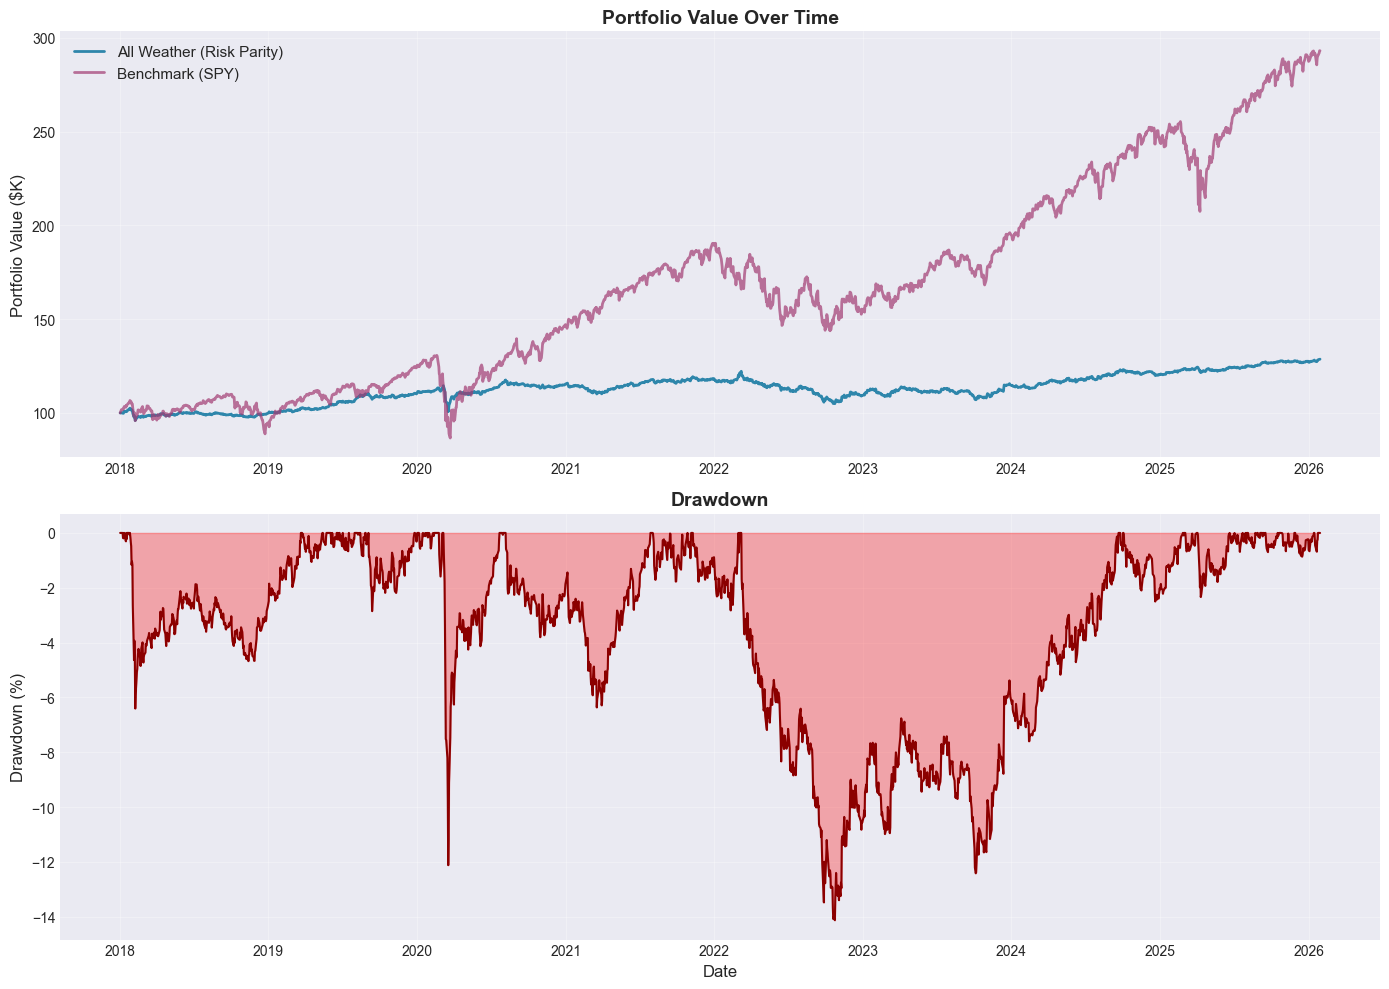

Max Drawdown: -14.13%


In [ ]:
equity = results['equity_curve']

# Create S&P 500 benchmark
benchmark = (prices['SPY'] / prices['SPY'].loc[equity.index[0]]) * 100_000
benchmark = benchmark.loc[equity.index]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Equity curve
ax1.plot(equity.index, equity / 1000, label='All Weather (Risk Parity)',
         linewidth=2, color='#2E86AB')
ax1.plot(benchmark.index, benchmark / 1000, label='Benchmark (SPY)',
         linewidth=2, alpha=0.7, color='#A23B72')
ax1.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($K)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Drawdown
running_max = equity.expanding().max()
drawdown = (equity - running_max) / running_max
ax2.fill_between(drawdown.index, drawdown * 100, 0, alpha=0.3, color='red')
ax2.plot(drawdown.index, drawdown * 100, color='darkred', linewidth=1.5)
ax2.set_title('Drawdown', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Max Drawdown: {drawdown.min():.2%}")

## 7. Performance Metrics

In [ ]:
# Calculate metrics
portfolio_returns = results['returns']
benchmark_returns = benchmark.pct_change().dropna()

portfolio_metrics = calculate_all_metrics(portfolio_returns, equity)
benchmark_metrics = calculate_all_metrics(benchmark_returns, benchmark)

# Create comparison table
comparison = pd.DataFrame({
    'All Weather (US)': [
        f"{portfolio_metrics['annual_return']:.2%}",
        f"{portfolio_metrics['annual_volatility']:.2%}",
        f"{portfolio_metrics['sharpe_ratio']:.2f}",
        f"{portfolio_metrics['sortino_ratio']:.2f}",
        f"{portfolio_metrics['max_drawdown']:.2%}",
        f"{portfolio_metrics['calmar_ratio']:.2f}",
        f"{portfolio_metrics['win_rate']:.2%}",
        f"{portfolio_metrics['var_95']:.2%}",
        f"{portfolio_metrics['cvar_95']:.2%}",
        f"{portfolio_metrics['skewness']:.2f}",
        f"{portfolio_metrics['kurtosis']:.2f}"
    ],
    'Benchmark (SPY)': [
        f"{benchmark_metrics['annual_return']:.2%}",
        f"{benchmark_metrics['annual_volatility']:.2%}",
        f"{benchmark_metrics['sharpe_ratio']:.2f}",
        f"{benchmark_metrics['sortino_ratio']:.2f}",
        f"{benchmark_metrics['max_drawdown']:.2%}",
        f"{benchmark_metrics['calmar_ratio']:.2f}",
        f"{benchmark_metrics['win_rate']:.2%}",
        f"{benchmark_metrics['var_95']:.2%}",
        f"{benchmark_metrics['cvar_95']:.2%}",
        f"{benchmark_metrics['skewness']:.2f}",
        f"{benchmark_metrics['kurtosis']:.2f}"
    ]
}, index=[
    'Annual Return',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio',
    'Max Drawdown',
    'Calmar Ratio',
    'Win Rate',
    'VaR (95%)',
    'CVaR (95%)',
    'Skewness',
    'Kurtosis'
])

print("\n" + "="*80)
print("PERFORMANCE METRICS (2018-{})".format(equity.index[-1].year))
print("="*80)
print(comparison)
print("="*80)


PERFORMANCE METRICS (2018-2026)
                  All Weather (US) Benchmark (SPY)
Annual Return                3.18%          14.30%
Annual Volatility            5.97%          19.40%
Sharpe Ratio                  0.03            0.58
Sortino Ratio                 0.04            0.71
Max Drawdown               -14.13%         -33.72%
Calmar Ratio                  0.23            0.42
Win Rate                    53.06%          55.47%
VaR (95%)                   -0.56%          -1.80%
CVaR (95%)                  -0.89%          -2.96%
Skewness                     -0.40           -0.30
Kurtosis                      6.02           13.15


## 8. Weight Evolution

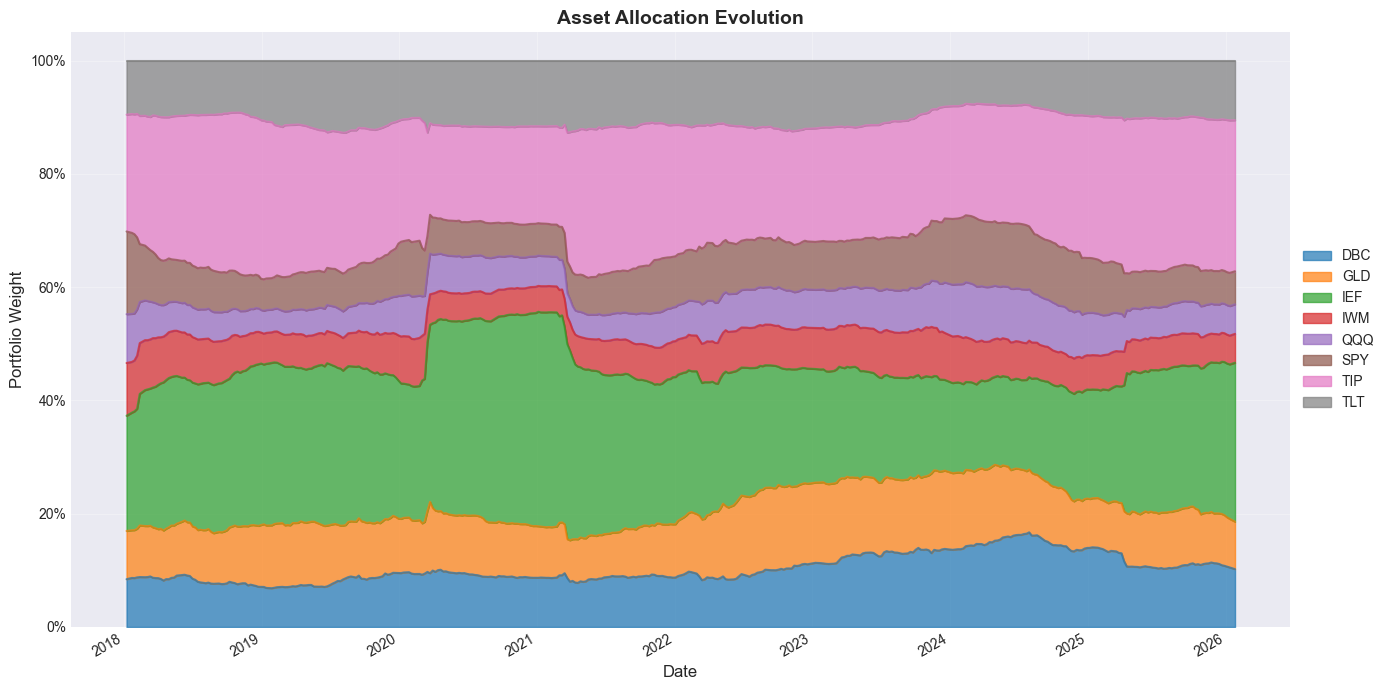


Latest Rebalance Weights:
  IEF   : 28.08%
  TIP   : 26.68%
  TLT   : 10.51%
  DBC   : 10.22%
  GLD   : 8.37%
  SPY   : 5.83%
  QQQ   : 5.22%
  IWM   : 5.10%


In [ ]:
weights_df = results['weights_history']

if not weights_df.empty:
    # Stacked area chart
    fig, ax = plt.subplots(figsize=(14, 7))
    weights_df.plot.area(stacked=True, ax=ax, alpha=0.7)
    ax.set_title('Asset Allocation Evolution', fontsize=14, fontweight='bold')
    ax.set_ylabel('Portfolio Weight', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
    plt.tight_layout()
    plt.show()
    
    # Show latest weights
    print("\nLatest Rebalance Weights:")
    latest = weights_df.iloc[-1].sort_values(ascending=False)
    for ticker, weight in latest.items():
        print(f"  {ticker:6}: {weight:.2%}")

## 9. Risk Analysis

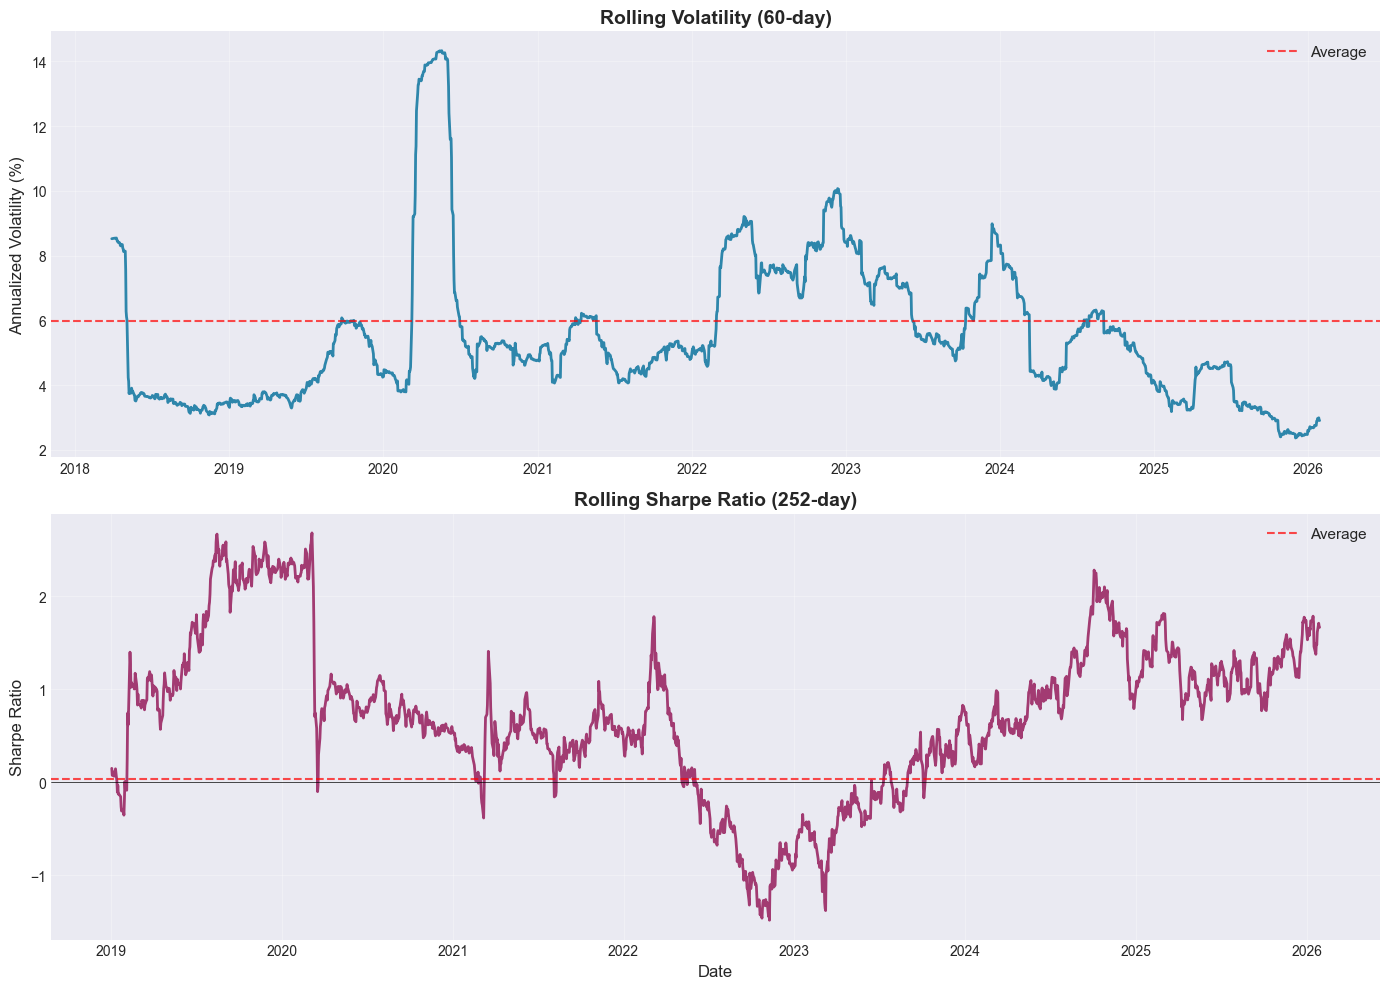

In [ ]:
# Rolling volatility and Sharpe ratio
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Rolling volatility (60-day)
rolling_vol = portfolio_returns.rolling(60).std() * np.sqrt(252) * 100
ax1.plot(rolling_vol.index, rolling_vol, linewidth=2, color='#2E86AB')
ax1.axhline(portfolio_metrics['annual_volatility'] * 100,
            color='red', linestyle='--', label='Average', alpha=0.7)
ax1.set_title('Rolling Volatility (60-day)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Annualized Volatility (%)', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Rolling Sharpe ratio (252-day)
rolling_sharpe = (
    portfolio_returns.rolling(252).mean() * 252 /
    (portfolio_returns.rolling(252).std() * np.sqrt(252))
)
ax2.plot(rolling_sharpe.index, rolling_sharpe, linewidth=2, color='#A23B72')
ax2.axhline(portfolio_metrics['sharpe_ratio'],
            color='red', linestyle='--', label='Average', alpha=0.7)
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title('Rolling Sharpe Ratio (252-day)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Sharpe Ratio', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Trading Instructions (US Markets)

Actionable trading plan for $10,000 initial capital.

In [ ]:
# Trading parameters
INITIAL_CAPITAL = 10_000  # $10,000 starting capital
COMMISSION_RATE = 0.001   # 0.1% commission

# Get current prices
current_prices = prices.iloc[-1]
current_date = prices.index[-1]

print("="*70)
print("ALL WEATHER US - TRADING INSTRUCTIONS")
print("="*70)
print(f"\nCurrent Date: {current_date.date()}")
print(f"Initial Capital: ${INITIAL_CAPITAL:,.0f}")
print(f"Commission Rate: {COMMISSION_RATE:.2%}")

# Calculate current allocation
current_allocation = strategy.get_current_allocation()
current_allocation['Target Value ($)'] = current_allocation['Weight'] * INITIAL_CAPITAL

print("\n" + "-"*70)
print("TARGET ALLOCATION")
print("-"*70)
print(current_allocation.to_string(index=False))

ALL WEATHER US - TRADING INSTRUCTIONS

Current Date: 2026-01-28
Initial Capital: $10,000
Commission Rate: 0.10%

----------------------------------------------------------------------
TARGET ALLOCATION
----------------------------------------------------------------------
Ticker  Weight  Allocation  Target Value ($)
   IEF  0.2813     28.1324         2813.2364
   TIP  0.2669     26.6873         2668.7273
   TLT  0.1054     10.5433         1054.3298
   DBC  0.1017     10.1718         1017.1795
   GLD  0.0823      8.2315          823.1456
   SPY  0.0586      5.8581          585.8100
   QQQ  0.0524      5.2425          524.2541
   IWM  0.0513      5.1332          513.3173


In [ ]:
# Calculate exact shares to buy
print("\n" + "="*70)
print("INITIAL PURCHASE INSTRUCTIONS")
print("="*70)
print(f"\nExecute on: {current_date.date()} (or next trading day)")
print("\n" + "-"*70)

trades = []
total_cost = 0
remaining_cash = INITIAL_CAPITAL

for _, row in current_allocation.iterrows():
    ticker = row['Ticker']
    target_value = row['Target Value ($)']
    price = current_prices[ticker]
    
    # Calculate whole shares (US stocks trade in single shares)
    shares = int(target_value / price)
    
    if shares > 0:
        cost = shares * price
        commission = cost * COMMISSION_RATE
        total_cost_with_commission = cost + commission
        
        if total_cost_with_commission <= remaining_cash:
            trades.append({
                'Ticker': ticker,
                'Shares': shares,
                'Price': price,
                'Cost': cost,
                'Commission': commission,
                'Total': total_cost_with_commission
            })
            remaining_cash -= total_cost_with_commission
            total_cost += total_cost_with_commission

trades_df = pd.DataFrame(trades)

print(f"{'Ticker':<8} {'Shares':>8} {'Price':>10} {'Cost':>12} {'Commission':>12} {'Total':>12}")
print("-"*70)

for _, row in trades_df.iterrows():
    print(f"{row['Ticker']:<8} {row['Shares']:>8,} {row['Price']:>10.2f} "
          f"${row['Cost']:>11,.2f} ${row['Commission']:>11,.2f} ${row['Total']:>11,.2f}")

print("-"*70)
print(f"{'TOTAL':<8} {'':<8} {'':<10} {'':<12} {'':<12} ${total_cost:>11,.2f}")
print(f"\nRemaining Cash: ${remaining_cash:,.2f}")
print(f"Total Invested: ${total_cost:,.2f} ({total_cost/INITIAL_CAPITAL:.1%})")


INITIAL PURCHASE INSTRUCTIONS

Execute on: 2026-01-28 (or next trading day)

----------------------------------------------------------------------
Ticker     Shares      Price         Cost   Commission        Total
----------------------------------------------------------------------
IEF            29      95.90 $   2,781.10 $       2.78 $   2,783.88
TIP            24     110.44 $   2,650.56 $       2.65 $   2,653.21
TLT            12      87.60 $   1,051.20 $       1.05 $   1,052.25
DBC            40      24.94 $     997.60 $       1.00 $     998.60
GLD             1     494.56 $     494.56 $       0.49 $     495.05
IWM             1     263.30 $     263.30 $       0.26 $     263.56
----------------------------------------------------------------------
TOTAL                                                  $   8,246.56

Remaining Cash: $1,753.44
Total Invested: $8,246.56 (82.5%)


In [ ]:
# Rebalancing schedule
from datetime import timedelta

print("\n" + "="*70)
print("REBALANCING SCHEDULE")
print("="*70)

# Find next Monday
days_ahead = 0 - current_date.weekday()
if days_ahead <= 0:
    days_ahead += 7
next_monday = current_date + timedelta(days=days_ahead)

print("\nNext 5 rebalancing dates (Weekly Mondays):")
for i in range(5):
    rebal_date = next_monday + timedelta(weeks=i)
    print(f"  {i+1}. {rebal_date.date()}")

print("\n⚠️  US MARKET REBALANCING NOTES:")
print("  - Rebalance every Monday (or next trading day if holiday)")
print("  - Use 252-day lookback to recalculate weights")
print("  - Commission: 0.1% per trade (typical for online brokers)")
print("  - US stocks trade in single shares (no lot requirements)")
print("  - Track portfolio value changes for next rebalance")


REBALANCING SCHEDULE

Next 5 rebalancing dates (Weekly Mondays):
  1. 2026-02-02
  2. 2026-02-09
  3. 2026-02-16
  4. 2026-02-23
  5. 2026-03-02

⚠️  US MARKET REBALANCING NOTES:
  - Rebalance every Monday (or next trading day if holiday)
  - Use 252-day lookback to recalculate weights
  - Commission: 0.1% per trade (typical for online brokers)
  - US stocks trade in single shares (no lot requirements)
  - Track portfolio value changes for next rebalance


## 11. Save Results

In [ ]:
# Save data for future use
save_us_data(prices, filepath='../data/us_etf_prices.csv')

# Export results
export_results = {
    'backtest_period': f"{equity.index[0].strftime('%Y-%m-%d')} to {equity.index[-1].strftime('%Y-%m-%d')}",
    'final_value': results['final_value'],
    'total_return': results['total_return'],
    'metrics': portfolio_metrics,
    'benchmark_metrics': benchmark_metrics
}

print("\n" + "="*70)
print("Results Summary")
print("="*70)
print(f"Backtest period: {export_results['backtest_period']}")
print(f"Final value: ${export_results['final_value']:,.0f}")
print(f"Total return: {export_results['total_return']:.2%}")
print(f"\n✓ All Weather US v1.1 backtest complete!")


✓ Saved data to ../data/us_etf_prices.csv
  Shape: (2784, 8)
  Size: 260.3 KB

Results Summary
Backtest period: 2018-01-02 to 2026-01-28
Final value: $128,682
Total return: 28.68%

✓ All Weather US v1.1 backtest complete!
